## Andy Soelistio
## Project 2: Investigate Dataset
## Oct-30-2018

# Project 2: Investigate a Dataset -- Four Asian Tigers: An Export-Led Economic Growth?

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a>
    <ul>
       <li><a href='#CleaningFirstStage'>Data Cleaning -- First Stage:  Make all column names and indexes in all dataframes identical</a></li>
       <li><a href='#CleaningSecondStage'>Data Cleaning -- Second Stage: Introducing a column into dataframes</a></li>
       <li><a href='#CleaningThirdStage'>Data Cleaning -- Third Stage: Combining Variables into a dataframe and Separating Dataframes based on GDP PerCapita's percentiles</a></li>
    </ul>
</li>
<li><a href="#eda">Exploratory Data Analysis</a>
    <ul>
       <li><a href='#resquestion1'>Research Question 1 -- Big Mac Index</a></li>
       <li><a href='#resquestion2'>Research Question 2 -- Investigating Correlation</a></li>
       <li><a href='#resquestion3'>Research Question 3 -- Investigating Single DataPoint: Singapore</a></li>
    </ul>
</li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> This project is inspired by the <a href='https://www.investopedia.com/terms/f/four-asian-tigers.asp'/>economic growth story of four Asian tigers </a>namely, Hong Kong, <br> Singapore, South Korean and Taiwan. 
These four countries were one of the poorest countries on <br>
earth at the end of 1945. By the year 2000, they can be considered <br>
developed nations. It was widely reported that their exceptional rise <br>
are due to their dependence of exports. Dependence on exports or export-led <br>
economic growth implies that their exports as a proportion of their GDPs are high. 
>
> This project will explore whether there is a correlation between exports as proportions of GDP <br>
and GDP per capita. Other independent (explanatory) variables related to exports that <br>
will be explored are Imports and  Foreign Direct Investment (as proportions of GDP).<br> 
There is one dependent (response) variable i.e., GDP per capita in US dollars. 
>
> This project is also inspired by a popular index -- <a href='https://www.worldatlas.com/articles/the-world-s-most-expensive-countries-measured-by-the-big-mac-index.html'/>Big Mac Index.</a> This project will <br>
attempt to show if eating big macs everyday are affordable in countries in the <br>
<a href='https://www.gapminder.org/data/'/>dataset obtained from gapminder.</a> 

In [1]:
# Use this cell to set up import statements for all of the packages that you
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker # for formatting ticks
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
import operator # to sort dict by values
import statistics
import statsmodels.api as sm


In [2]:
#================================================================
        # The following are API Functions used mainly 
        # in Data Wrangling Section
#================================================================

# default: columns 65% filled
# drop columns that are 35% NaN
def drop_df_columns(df,perct_filled=0.65):
    columns_dropped = columns_tobedropped(df,perct_filled)
    if len(columns_dropped) == 0:
        return 'Nothing to drop'
    else:
        df.drop(columns_dropped,axis=1,inplace=True)
        return 'Done'

# regular dropping dataframe columns
def drop_cols(df,desired_list):
    rejected_list = np.setdiff1d(df.columns,desired_list).tolist()
    df.drop(rejected_list,axis=1,inplace=True)

def drop_index(df,desired_index):
    rejected_index= np.setdiff1d(df.index,desired_index).tolist()
    df.drop(axis=0,index=rejected_index,inplace=True)
    
def fillna_with_mean(df):
    mask = df.isnull().sum() != 0
    fill_cols_list = df.isnull().sum()[mask]
    for k,value in enumerate(fill_cols_list.index):
        mean_val = df[value].mean()
        df.fillna(mean_val,axis=1,inplace=True)

# https://www.geeksforgeeks.org/python-program-find-common-elements-three-lists-using-sets/
# make this generic. therefore not just fixed 5 lists (if I have time).
def andy_IntersectSets(list1, list2, list3, list4,list5):
    s1 = set(list1)
    s2 = set(list2)
    s3 = set(list3)
    s4 = set(list4)
    s5 = set(list5)
    
    set1 = s1.intersection(s2)
    set2 = set1.intersection(s3)
    set3 = set2.intersection(s4)
    result_set = set3.intersection(s5)
    final_list = list(result_set)
    return final_list

def andy_IntersectSets2(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    
    set1 = s1.intersection(s2)
    final_list = list(set1)
    return final_list
#==================================================================================
#   don't use this. this is private helper function used by 'contract' API function
#==================================================================================  
    
def columns_tobedropped(df,perct_filled):  
    data_tobedropped = []
    for col in df.columns:
        null_count = df[col].isnull().sum()
        proportion = null_count / df.shape[0]  #proportion that is null; higher more null values
        if proportion <= (1-perct_filled):
            #data_80filled.append(col)
            continue
        else:
            data_tobedropped.append(col)
    #print(data_tobedropped)
    return data_tobedropped

In [3]:
#================================================================
        # The following are API Functions used mainly 
        # in Exploratory Data Section
#================================================================

#return a tuple (sum,mean) of a row
def find_sum_mean_row(df):
    total_row = 0
    for column in df.columns[1:]:
        total_row += df[column]
    mean_row =  total_row/len(df.columns[1:])
    return total_row,mean_row

def common_plotting_format():
    plt.yticks(fontsize=12)
    plt.ylabel('',fontsize=12)
    plt.show()

def common_ticks_legends_format(tickSize,legendSize):
    plt.xticks(fontsize=tickSize)
    plt.yticks(fontsize=tickSize)
    plt.legend(fontsize=legendSize)

def common_ticks_format(tickSize):
    plt.xticks(fontsize=tickSize)
    plt.yticks(fontsize=tickSize)

def remove_outliers(values):
    mid_quantiles = values.quantile([.15, .60])
    return np.mean(mid_quantiles)

def money(x):
    return "${:,.0f}".format(x)

def pretty_number(x):
     return "{:,.0f}".format(x)    

#moving average
def simplifiedRollingMean(windowRolling, df_i):
    df_o = df_i.rolling(window = windowRolling, center=False, on = "index").mean().dropna()
    return df_o

#---can buy big mac everyday for lunch?
# price of big mac in USA: $5.04 since GDP is in US Dollar
# For a year 5.04 x 365 = 1,840
#https://www.businessinsider.com/big-mac-cost-around-the-world-2017-1/?IR=T
BIG_MAC_EVERYDAY = 1840

def calc_z_score_given_value(data_series,val):
    mean_val = np.mean(data_series)
    std_val = np.std(data_series)
    z_score = (val - mean_val)/std_val
    return z_score

# values used in plotting graph 
def calc_mean_within_std1_std2_right(data_series):
    mean_val = np.mean(data_series)
    within_std_1 = mean_val + np.std(data_series,ddof=1)
    within_std_2 = within_std_1 + np.std(data_series,ddof=1)
    return mean_val,within_std_1,within_std_2

# values used in plotting graph 
def calc_mean_within_std1_std2_left(data_series):
    mean_val = np.mean(data_series)
    within_std_1 = mean_val - np.std(data_series,ddof=1)
    within_std_2 = within_std_1 - np.std(data_series,ddof=1)
    return mean_val,within_std_1,within_std_2

# Not tested yet!!!
def plot_axvline_mean_std(data_series):
    mean_val,within_std1_right,within_std2_right = calc_mean_within_std1_std2_right(data_series)
    mean_val = int(mean_val)
    within_std1_right = int(within_std1_right)
    within_std2_right = int(within_std2_right)
    plt.axvline(mean_val,c='black',label='mean: ' + pretty_number(mean_val))
    plt.axvline(within_std1_right,c='yellow',label='std1 right: ' + pretty_number(within_std1_right))
    plt.axvline(within_std2_right,c='orange',label='std2 right: ' + pretty_number(within_std2_right))
    
    mean_val,within_std1_left,within_std2_left = calc_mean_within_std1_std2_left(data_series)
    # don't have to plot mean; already drawn above
    within_std1_left = int(within_std1_left)
    within_std2_left = int(within_std2_left)
    plt.axvline(within_std1_left,c='yellow',label='std1 left: ' + pretty_number(within_std1_left))
    plt.axvline(within_std2_left,c='orange',label='std2 left: ' + pretty_number(within_std2_left))

<a id='wrangling'></a>
## Data Wrangling

>
>At the end of this step -- Data Wrangling -- a clean dataframe will be produced. <br> 
<a href='#clean_dataframes'/>Click this link for the final clean dataframes.</a>


In [4]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df_exports = pd.read_excel('raw/Exports (p of GDP).xlsx',index_col=0)
df_fdi = pd.read_excel('raw/Foreign investment inflow.xlsx',index_col=0)  # % of GDP
df_gdp_percapita = pd.read_excel('raw/GDPpercapitaconstant2000US.xlsx',index_col=0)
df_imports = pd.read_excel('raw/Imports (p of GDP).xlsx',index_col=0)
df_gdp_market = pd.read_excel('raw/total_gdp_market_prices.xlsx',index_col=0)


In [5]:
# This dataframe represents Exports of goods and services as a % GDP from year 1961 to 2011
# This is independent variable
df_exports.head(2)

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011
Exports of goods and services (% of GDP),,,,,,,,,,,,,,,,,,,,,
Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Afghanistan,4.453443,4.878051,9.171601,8.888893,11.258279,8.571429,6.772908,8.899677,10.094637,9.784002,...,32.438501,42.2955,32.93117,30.550988,27.640178,22.926131,26.67612,22.860093,20.124519,18.106142


In [6]:
# This dataframe represents Foreign Direct Investment as a % of GDP from year 1970 to 2011
# This is independent variable
df_fdi.head(2)

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011
"Foreign direct investment, net inflows (% of GDP)",,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.013151,0.024575,0.009401,0.015577,NaN,NaN,0.001565,-0.008126,NaN,0.03245,...,1.152364,1.212725,3.276532,3.976666,3.082130,2.503252,2.51250,1.301564,0.438726,NaN
Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.034135,3.149791,4.572142,3.133523,3.561523,6.186838,7.39089,8.008638,9.414123,NaN


In [7]:
# This dataframe represents GDP per capita in US Dollars from 1960 to 2011
# This is the target for this project. A dependent variable
df_gdp_percapita.head(2)

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011
Income per person (fixed 2000 US$),,,,,,,,,,,,,,,,,,,,,
Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# This dataframe represents Imports of Goods and Services as % of GDP from 1960 to 2011
# This is a independent variable
df_imports.head(2)

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011
Imports of goods and services (% of GDP),,,,,,,,,,,,,,,,,,,,,
Afghanistan,7.024793,8.097166,9.349593,16.86391,18.055555,21.412804,18.571429,14.209827,15.210356,14.984227,...,61.599727,90.84032,77.566508,71.264727,67.70616,59.000138,47.654833,59.915922,53.562257,NaN
Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,46.716601,45.87424,43.306502,46.326121,49.15114,54.964723,56.119277,54.235682,51.752734,NaN


In [9]:
# This dataframe represents GDP in US dollars using year 2000 as base year.
# This GDP is not in Purchasing Power Parity (PPP)
# This is independent variable
df_gdp_market.head(2)

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011
GDP (constant 2000 US$),,,,,,,,,,,,,,,,,,,,,
Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a id='CleaningFirstStage'></a>
### Data Cleaning -- First Stage: Make all column names and indexes in all dataframes identical

>In this first Stage, the goal is to make all dataframes to have identical number <br>
>of indexes and columns. 
>
><ul/>
><li/>First, I will transpose all dataframes. The reason why I transpose dataframes is given below.</li/>
<br>
><li/>Second, I will drop columns based on this criteria: if the columns contain 40% or more NaN,
>I will drop the column.</li>
<br>
><li/>Third, I will use the <a href='https://www.geeksforgeeks.org/python-program-find-common-elements-three-lists-using-sets/'/> intersection technique </a>to obtain common columns. So all column names in all <br>
>dataframes will be identical. </li><br>
><li/>Fourth, I will use the same intersection  technique to obtain identical indexes</li>
<br>
><li/>Fifth, fill NaN with the mean of each column</li>
</ul>
>
>At the end of the this state, all column names and indexes will be identical in all <br>
>dataframes. The index 'year' will be an int type. Finally, save all dataframes into clean folder.

**Why I transpose my dataframe?**

>Because initially I thought, it's easier to work with countries as columns.<br>
For exampe df['Country'] instead of df[Years...]
>
>Later I realize having countries as index is also very useful when using pd.pivot_table.<br>
>Inspiration <a href='https://www.dataquest.io/blog/pandas-pivot-table/'/>from this link.</a> 
>
>At this stage, I was forced to think about independent and dependent variables.<br>
I also read DAND's Section 3 of Lesson 14: Regression. It clears up my understanding <br>
of independent (explanatory) and dependent (response) variables.  <br>
I designate GDP per capita as my dependent variable.<br>
Exports, FDI, Imports and GDP_market will be my independent variables.
>
>But as after thought, both format -- original and transposed -- are equally<br>
important, if you know what purpose each format serves.

In [10]:
# Transpose all DataFrames
df_exports_T = df_exports.T
df_fdi_T = df_fdi.T
df_gdp_percapita_T = df_gdp_percapita.T
df_imports_T = df_imports.T
df_gdp_market_T = df_gdp_market.T

#Make a Transposed DataFrame list
df_lists_T = [df_exports_T,df_fdi_T,df_gdp_percapita_T,df_imports_T,df_gdp_market_T]

In [11]:
# Transposed DataFrame. So now index is years and columns are countries
# I only do one for df_exports_T dataframe.
# I won't print the heads of df_fdi_T, df_gdp_percapita_T, df_imports_T, and df_gdp_market_T.
df_exports_T.head(2)

Exports of goods and services (% of GDP),Abkhazia,Afghanistan,Akrotiri and Dhekelia,Albania,Algeria,American Samoa,Andorra,Angola,Anguilla,Antigua and Barbuda,...,Antarctica,"Virgin Islands, British",Hawaiian Trade Zone,U.S. Pacific Islands,Wake Island,Bonaire,Sark,Chinese Taipei,Saint Eustatius,Saba
1961,NaN,4.453443,NaN,NaN,46.244557,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962,NaN,4.878051,NaN,NaN,19.793872,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_exports_T.shape,df_fdi_T.shape,df_gdp_percapita_T.shape,df_imports_T.shape,df_gdp_market_T.shape

((51, 275), (42, 213), (52, 275), (52, 213), (52, 270))

In [13]:
# Drop columns so data is at least 60% filled and 40% NaN in *each column*
# Therefore, if a country column contains more than 20% NaN, it will be dropped!
for df_T in df_lists_T:
    drop_df_columns(df_T,0.60)

In [14]:
# Note the shape[1].
# For exports, column countries have been dropped from 275 --> 138
# For fdi, column countries have been dropped from 213 --> 134
# For gdp_percapita, column countries have been dropped from 275 --> 142
# For imports, column countries have been dropped from 213 --> 123
# For gdp_market, column countries have been dropped from 270 --> 140
# Note: the column countries are different. The goal is to make them the same numbers.
# I will use the concept of merging two SQL table with Inner Join as demonstrated
# in case study 2 of Udacity DAND. 
# In my case, I use andy_IntersectSets()
df_exports_T.shape,df_fdi_T.shape,df_gdp_percapita_T.shape,df_imports_T.shape,df_gdp_market_T.shape

((51, 138), (42, 134), (52, 142), (52, 123), (52, 140))

In [15]:
#Now we reduce the country columns to be the same. we want the intersections of these columns. IOW merging INNER JOIN
desired_list = andy_IntersectSets(df_exports_T.columns.tolist(),df_fdi_T.columns.tolist(), \
                    df_gdp_percapita_T.columns.tolist(),df_imports_T.columns.tolist(),df_gdp_market_T.columns.tolist())
print("These countries in the desired list will be used in our project because each column contains at least 60% filled data")
print("Number of countries that will be used {0}.".format(len(desired_list)))
print("\n")
print(desired_list)

These countries in the desired list will be used in our project because each column contains at least 60% filled data
Number of countries that will be used 107.


['Colombia', 'Congo, Dem. Rep.', 'Austria', 'Thailand', 'Nicaragua', 'United States', 'Papua New Guinea', 'Mexico', 'Mauritania', 'Togo', 'Malta', 'Benin', 'Burundi', 'Greece', 'India', 'Gambia', 'Gabon', 'Germany', 'Mauritius', 'Lesotho', 'Iran', 'Turkey', 'Burkina Faso', 'Barbados', 'Ghana', 'Uruguay', 'Zimbabwe', 'Congo, Rep.', 'Mali', 'Syria', 'Nigeria', 'Honduras', 'Bangladesh', 'China', 'Botswana', 'Kiribati', 'Jamaica', 'Morocco', 'Tunisia', 'Cuba', 'Malaysia', 'Costa Rica', 'Bahamas', 'Norway', 'Cameroon', 'Oman', 'Swaziland', 'Egypt', 'Nepal', 'Zambia', 'Guinea-Bissau', 'Kenya', 'Paraguay', 'Algeria', 'Ecuador', 'Finland', 'Australia', 'Brazil', 'New Zealand', 'Iceland', 'Bolivia', 'Israel', 'Italy', 'Fiji', 'Suriname', 'Philippines', 'Niger', 'Japan', 'Grenada', 'Spain', 'South Africa', 'Peru', 'Guatemala', 'France'

In [16]:
#now drop columns country that we don't want ie., countries not in the desired list
for df_T in df_lists_T:
    drop_cols(df_T,desired_list)

In [17]:
#Resulting dataframes. Note all shape[1] have the same number
df_exports_T.shape,df_fdi_T.shape,df_gdp_percapita_T.shape,df_imports_T.shape,df_gdp_market_T.shape

((51, 107), (42, 107), (52, 107), (52, 107), (52, 107))

In [18]:
#Confirmed all columns are identical
(df_exports_T.columns == df_fdi_T.columns ).all(),(df_exports_T.columns == df_gdp_percapita_T.columns ).all(), \
    (df_exports_T.columns == df_imports_T.columns ).all(),(df_exports_T.columns == df_gdp_market_T.columns).all()

(True, True, True, True)

In [19]:
# dropping rows that contain *ALL* NaN
for df_T in df_lists_T:
    df_T.dropna(axis=0,how='all',inplace=True)

In [20]:
# rows containing all NaN are dropped
# Note: shape[0] are not identical because index Year are not identical
# For example dataframe df_fdi_T contain year from 1970 to 2011 while most dataframes
# have index Year from 1960 to 2011. We have to make this index Year identical too.
df_exports_T.shape,df_fdi_T.shape,df_gdp_percapita_T.shape,df_imports_T.shape,df_gdp_market_T.shape

((51, 107), (41, 107), (52, 107), (51, 107), (52, 107))

In [21]:
#Since indexes are years. make it an int type
for df_T in df_lists_T:
    df_T.index = df_T.index.astype(int)

In [22]:
# Now index is all integers. I only print out df_exports_T. The rest
# of dataframes'index will be integers too.
df_exports_T.index

Int64Index([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
            1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
            1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
            1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
            2005, 2006, 2007, 2008, 2009, 2010, 2011],
           dtype='int64')

In [23]:
#Make all indexes identical in all dataframes
desired_index = andy_IntersectSets(df_exports_T.index.tolist(),df_fdi_T.index.tolist(), \
                   df_gdp_percapita_T.index.tolist(),df_imports_T.index.tolist(), \
                   df_gdp_market_T.index.tolist())
desired_index.sort()
for df_T in df_lists_T:
    drop_index(df_T,desired_index)

In [24]:
# all dataframes identical
df_exports_T.shape,df_fdi_T.shape,df_gdp_percapita_T.shape,df_imports_T.shape,df_gdp_market_T.shape

((41, 107), (41, 107), (41, 107), (41, 107), (41, 107))

In [25]:
#Confirmed all indexes are identical
(df_exports_T.index == df_fdi_T.index ).all(),(df_exports_T.index == df_gdp_percapita_T.index ).all(), \
    (df_exports_T.index == df_imports_T.index ).all(),(df_exports_T.index == df_gdp_market_T.index).all()

(True, True, True, True)

In [26]:
# Now fill NaN cells with mean of respective column/country
for df_T in df_lists_T:
    fillna_with_mean(df_T)

In [27]:
# Confirm all dataframes contain no null values

In [28]:
mask=df_exports_T.isnull().sum() != 0
df_exports_T.isnull().sum()[mask]

Series([], dtype: int64)

In [29]:
mask=df_fdi_T.isnull().sum() != 0
df_fdi_T.isnull().sum()[mask]

Series([], dtype: int64)

In [30]:
mask=df_gdp_percapita_T.isnull().sum() != 0
df_gdp_percapita_T.isnull().sum()[mask]

Series([], dtype: int64)

In [31]:
mask=df_imports_T.isnull().sum() != 0
df_imports_T.isnull().sum()[mask]

Series([], dtype: int64)

In [32]:
mask=df_gdp_market_T.isnull().sum() != 0
df_gdp_market_T.isnull().sum()[mask]

Series([], dtype: int64)

In [33]:
# Therefore all dataframes contain no NaN
# so save data in a clean folder
# Note: these are all transposed dataframes.
df_exports_T.to_csv('clean/exportsT.csv')
df_fdi_T.to_csv('clean/fdiT.csv')
df_gdp_percapita_T.to_csv('clean/gdppercapitaT.csv')
df_imports_T.to_csv('clean/importsT.csv')
df_gdp_market_T.to_csv('clean/gdp_marketT.csv')

<a id='CleaningSecondStage'></a>
### Data Cleaning -- Second Stage: Introducing a column into dataframes

><ul/><li/>I will introduce a column, 'sub-region' in this stage. Therefore, if Afghanistan 
>is in Southern Asia, there will be a column for that. I can use an operation
>like groupby on this 'sub-region' column. It works similar to SQL GROUPBY.
>You can easily organize your data by aggregating.</li>
><br>
><li/>I download country_codes.xlsx from gapminder to help me merge and include
>sub-region columns into all my dataframes. Or I could have searched the Internet
>for libraries that are related to country_codes. This page teaches me
><a href='http://pbpython.com/excel-pandas-comp.html'/>how to do vlookup.</a> It uses the fuzzywuzzy library</li>
><br>
><li/>The problem I encountered is when I tried to merge the files. 10 countries are 
>omitted. For example in the dfc_exports dataframe, the country has a name called Iran.
>In country_codes dataframe, the country has a name 'Iran (Islamic Republic of)'.
>I have to make sure that country's names are identical in both dataframes.
>I corrected this mannually, which is not a hassle for a small data. In a big data
>I have to find other ways such as looking up country_codes library.</li>
><br>
><li/>At the end of this stage, all dataframes will have a column called 'sub-region'.</li>
</ul>

In [34]:
#Reading from clean data produced above
dfc_exports_T = pd.read_csv('clean/exportsT.csv',index_col=0)  # p of GDP
dfc_fdi_T = pd.read_csv('clean/fdiT.csv',index_col=0)  # % of GDP
dfc_gdp_percapita_T = pd.read_csv('clean/gdppercapitaT.csv',index_col=0)  # constant2000US
dfc_imports_T = pd.read_csv('clean/importsT.csv',index_col=0)  # % of GDP
dfc_gdp_market_T = pd.read_csv('clean/gdp_marketT.csv',index_col=0)

#This is a new file to be used in introducing sub-region
df_country_codes = pd.read_excel('clean/country_codes.xlsx')

In [35]:
dfc_exports_T.shape

(41, 107)

In [36]:
#Transpose data to original format -- index: countries, columns: years
dfc_exports = dfc_exports_T.T
dfc_fdi = dfc_fdi_T.T
dfc_gdp_percapita = dfc_gdp_percapita_T.T
dfc_imports = dfc_imports_T.T
dfc_gdp_market = dfc_gdp_market_T.T

In [37]:
dfc_exports.shape

(107, 41)

In [38]:
dfc_exports.head()

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
Algeria,22.072734,18.442519,20.449562,25.503663,38.749044,33.688936,33.054584,30.586567,25.535837,31.148300,...,36.247991,35.076150,38.266470,40.071885,47.646353,48.607848,46.609494,46.273658,29.289305,30.830405
Antigua and Barbuda,68.531756,68.531756,68.531756,68.531756,68.531756,68.531756,68.531756,47.701439,61.600119,81.786790,...,60.316271,55.788811,57.588400,58.995136,54.419679,48.025321,44.855895,46.165740,46.251306,45.402342
Argentina,5.601567,6.007233,7.197766,7.612668,6.902571,5.824052,9.175388,9.615892,8.608390,6.510915,...,11.528611,27.689676,24.971195,25.257467,25.067933,24.759447,24.626547,24.475413,21.351174,21.706469
Australia,12.972812,12.657506,12.826336,14.150754,13.145018,14.281698,13.518254,14.021153,13.628044,14.307879,...,22.067634,20.633342,18.915085,17.042724,18.113278,19.696764,20.016897,19.882920,22.725356,19.620065
Austria,28.455043,28.084806,27.976054,27.964316,30.244524,29.185206,29.868635,29.039067,30.245275,32.079497,...,48.078408,48.684627,48.241328,51.484081,53.838949,56.361756,58.899795,59.267232,50.064418,54.103261


In [39]:
df_country_codes.head()

,name,sub-region
0,Afghanistan,Southern Asia
1,Albania,Southern Europe
2,Algeria,Northern Africa
3,American Samoa,Polynesia
4,Andorra,Southern Europe


In [40]:
# Have to manually edit country_codes.xlsx. This file I think
# I download from gapminder. I could have used the method 
# used here: http://pbpython.com/excel-pandas-comp.html by using
# library but I have to find library for country codes. But
# I think for a small data like country_codes, it's easier to
# manually edit.
#
# If I don't edit, 10 countries will not be included
#
# Empty list means all countries have been included!
common_list = andy_IntersectSets2(dfc_exports.index.tolist(),df_country_codes['name'].tolist())
np.setdiff1d(dfc_exports.index,common_list).tolist()

[]

In [41]:
# Merge dataframe exports with country_codes dataframe using INNER JOIN
dfc_exports_M = pd.merge(left=dfc_exports,right=df_country_codes,how='inner',left_on=dfc_exports.index,right_on='name')
# Re-ordering columns. There must be a better way of doing this.
dfc_exports_M = dfc_exports_M[['name','sub-region', \
                    1970,1971,1972,1973,1974,1975,1976,1977,1978,1979, \
                    1980,1981,1982,1983,1984,1985,1986,1987,1988,1989, \
                    1990,1991,1992,1993,1994,1995,1996,1997,1998,1999, \
                    2000,2001,2002,2003,2004,2005,2006,2007,2008,2009, \
                    2010]]
dfc_exports_M.set_index('name',inplace=True)
dfc_exports_M.shape

(107, 42)

In [42]:
# Merge dataframe fdi with country_codes dataframe using INNER JOIN
dfc_fdi_M = pd.merge(left=dfc_fdi,right=df_country_codes,how='inner', \
                   left_on=dfc_fdi.index,right_on='name')
# Re-ordering columns. There must be a better way of doing this.
dfc_fdi_M = dfc_fdi_M[['name','sub-region', \
                    1970,1971,1972,1973,1974,1975,1976,1977,1978,1979, \
                    1980,1981,1982,1983,1984,1985,1986,1987,1988,1989, \
                    1990,1991,1992,1993,1994,1995,1996,1997,1998,1999, \
                    2000,2001,2002,2003,2004,2005,2006,2007,2008,2009, \
                    2010]]
dfc_fdi_M.set_index('name',inplace=True)
dfc_fdi_M.shape

(107, 42)

In [43]:
# Merge dataframe gdp_percapita with country_codes dataframe using INNER JOIN
dfc_gdp_percapita_M = pd.merge(left=dfc_gdp_percapita,right=df_country_codes,how='inner', \
                   left_on=dfc_gdp_percapita.index,right_on='name')
# Re-ordering columns. There must be a better way of doing this.
dfc_gdp_percapita_M = dfc_gdp_percapita_M[['name','sub-region', \
                    1970,1971,1972,1973,1974,1975,1976,1977,1978,1979, \
                    1980,1981,1982,1983,1984,1985,1986,1987,1988,1989, \
                    1990,1991,1992,1993,1994,1995,1996,1997,1998,1999, \
                    2000,2001,2002,2003,2004,2005,2006,2007,2008,2009, \
                    2010]]
dfc_gdp_percapita_M.set_index('name',inplace=True)
dfc_gdp_percapita_M.shape

(107, 42)

In [44]:
# Merge dataframe imports with country_codes dataframe using INNER JOIN
dfc_imports_M = pd.merge(left=dfc_imports,right=df_country_codes,how='inner', \
                   left_on=dfc_imports.index,right_on='name')
# Re-ordering columns. There must be a better way of doing this.
dfc_imports_M = dfc_imports_M[['name','sub-region', \
                    1970,1971,1972,1973,1974,1975,1976,1977,1978,1979, \
                    1980,1981,1982,1983,1984,1985,1986,1987,1988,1989, \
                    1990,1991,1992,1993,1994,1995,1996,1997,1998,1999, \
                    2000,2001,2002,2003,2004,2005,2006,2007,2008,2009, \
                    2010]]
dfc_imports_M.set_index('name',inplace=True)
dfc_imports_M.shape

(107, 42)

In [45]:
# Merge dataframe gdp_market with country_codes dataframe using INNER JOIN
dfc_gdp_market_M = pd.merge(left=dfc_gdp_market,right=df_country_codes,how='inner', \
                   left_on=dfc_gdp_market.index,right_on='name')
# Re-ordering columns. There must be a better way of doing this.
dfc_gdp_market_M = dfc_gdp_market_M[['name','sub-region', \
                    1970,1971,1972,1973,1974,1975,1976,1977,1978,1979, \
                    1980,1981,1982,1983,1984,1985,1986,1987,1988,1989, \
                    1990,1991,1992,1993,1994,1995,1996,1997,1998,1999, \
                    2000,2001,2002,2003,2004,2005,2006,2007,2008,2009, \
                    2010]]
dfc_gdp_market_M.set_index('name',inplace=True)
dfc_gdp_market_M.shape

(107, 42)

In [46]:
#Now all dataframes have sub-region column. so can do groupby this column.
# save merged data in a clean folder
dfc_exports_M.to_csv('clean/exportsM.csv')
dfc_fdi_M.to_csv('clean/fdiM.csv')
dfc_gdp_percapita_M.to_csv('clean/gdppercapitaM.csv')
dfc_imports_M.to_csv('clean/importsM.csv')
dfc_gdp_market_M.to_csv('clean/gdp_marketM.csv')

<a id='CleaningThirdStage'></a>
### Data Cleaning -- Third Stage: Combining Variables into a dataframe and Separating     Dataframes based on GDP PerCapita's percentiles

Cleaning data and putting data in this format at this stage enables me to use <a href='#using_pivot_table'>pandas.pivot_table.</a>

><ul/>
><li/>**First**, calculate the mean for gdp_percapita, exports, imports, fdi and gdp.
>Name these columns: mean_gdp_percapita, mean_exports, mean_imports, mean_fdi and
>mean_gdp, resectively</li><br>
><li/>**Second**, combine these columns into a new dataframe. I name it df_combined.
><a href='https://www.dataquest.io/blog/pandas-pivot-table/'/>Refer to this site for the format I want my dataframe to be.</a></li><br>
><li/>**Third**, separate dataframes into 1.below_average, 2.average, and 
>3.above_average. This separation is based upon gdp_percapita's percentiles.
>For details, <a href='#sep_columns'/>click here.</a></li>
><br><br>
>**At the end of this stage, I will have four clean dataframes:**
><ol/>
><li> df_combined_economic_status -- This df is a dataframe before it is separated into
>economic status (based on gdp_percapita's percentiles).</li>
><li> df_combined_belowaverage_subset </li>
><li> df_combined_50_75_subset</li>
><li> df_combined_above75_subset</li>
></ul>
></ol>

In [47]:
# Loading data
dfc_exports_T = pd.read_csv('clean/exportsT.csv',index_col=0)  # p of GDP
dfc_fdi_T = pd.read_csv('clean/fdiT.csv',index_col=0)  # % of GDP
dfc_gdp_percapita_T = pd.read_csv('clean/gdppercapitaT.csv',index_col=0)  # constant2000US
dfc_imports_T = pd.read_csv('clean/importsT.csv',index_col=0)  # % of GDP
dfc_gdp_market_T = pd.read_csv('clean/gdp_marketT.csv',index_col=0)

dfc_exports_M = pd.read_csv('clean/exportsM.csv',index_col=0)  # p of GDP
dfc_fdi_M = pd.read_csv('clean/fdiM.csv',index_col=0)  # % of GDP
dfc_gdp_percapita_M = pd.read_csv('clean/gdppercapitaM.csv',index_col=0)  # constant2000US
dfc_imports_M = pd.read_csv('clean/importsM.csv',index_col=0)  # % of GDP
dfc_gdp_market_M = pd.read_csv('clean/gdp_marketM.csv',index_col=0)

In [48]:
dfc_gdp_percapita_M.head(1)

,sub-region,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
name,,,,,,,,,,,,,,,,,,,,,
Algeria,Northern Africa,1436.129775,1235.663803,1527.646365,1538.306425,1603.34962,1632.296018,1714.070053,1747.665127,1848.437508,...,1814.41513,1871.921986,1971.512803,2043.135713,2115.186028,2124.957754,2155.485231,2173.787903,2192.703976,2231.980246


In [49]:
# Need to find total and mean gdp_percapita.
# Finding the total of gdp_percapita of a country means totaling the row from year 1970 to 2010
# Finding the mean of gdp_percapita of a country means dividing the total of that country 
# divided by the total number of years we take the sample from.
total_row,mean_row = find_sum_mean_row(dfc_gdp_percapita_M)
dfc_gdp_percapita_M['total_percapita_row'] = total_row
dfc_gdp_percapita_M['mean_percapita_row'] = mean_row
dfc_gdp_percapita_M.reset_index(inplace=True)
dfc_gdp_percapita_M.head(1)

,name,sub-region,1970,1971,1972,1973,1974,1975,1976,1977,...,2003,2004,2005,2006,2007,2008,2009,2010,total_percapita_row,mean_percapita_row
0,Algeria,Northern Africa,1436.129775,1235.663803,1527.646365,1538.306425,1603.34962,1632.296018,1714.070053,1747.665127,...,1971.512803,2043.135713,2115.186028,2124.957754,2155.485231,2173.787903,2192.703976,2231.980246,75174.781784,1833.531263


In [50]:
total_row,mean_row = find_sum_mean_row(dfc_exports_M)
dfc_exports_M['total_exports_row'] = total_row
dfc_exports_M['mean_exports_row'] = mean_row
dfc_exports_M.reset_index(inplace=True)
dfc_exports_M.head(1)

,name,sub-region,1970,1971,1972,1973,1974,1975,1976,1977,...,2003,2004,2005,2006,2007,2008,2009,2010,total_exports_row,mean_exports_row
0,Algeria,Northern Africa,22.072734,18.442519,20.449562,25.503663,38.749044,33.688936,33.054584,30.586567,...,38.26647,40.071885,47.646353,48.607848,46.609494,46.273658,29.289305,30.830405,1216.131812,29.661752


In [51]:
total_row,mean_row = find_sum_mean_row(dfc_imports_M)
dfc_imports_M['mean_imports_row'] = mean_row
dfc_imports_M.reset_index(inplace=True)
dfc_imports_M.head(1)

,name,sub-region,1970,1971,1972,1973,1974,1975,1976,1977,...,2002,2003,2004,2005,2006,2007,2008,2009,2010,mean_imports_row
0,Algeria,Northern Africa,29.152668,27.663778,25.726868,31.589764,35.489776,42.965599,37.118673,41.740317,...,25.399971,23.874279,25.652123,24.269903,21.516682,23.293057,22.90863,24.820752,21.496679,26.967667


In [52]:
total_row,mean_row = find_sum_mean_row(dfc_fdi_M)
dfc_fdi_M['mean_fdi_row'] = mean_row
dfc_fdi_M.reset_index(inplace=True)
dfc_fdi_M.head(1)

,name,sub-region,1970,1971,1972,1973,1974,1975,1976,1977,...,2002,2003,2004,2005,2006,2007,2008,2009,2010,mean_fdi_row
0,Algeria,Northern Africa,1.647378,0.011817,0.613595,0.585191,2.710127,0.764883,1.054808,0.850913,...,1.866684,0.931657,1.037359,1.056292,1.532824,1.223827,1.517639,1.998263,1.414501,0.73115


In [53]:
total_row,mean_row = find_sum_mean_row(dfc_gdp_market_M)
dfc_gdp_market_M['mean_gdp_row'] = mean_row
dfc_gdp_market_M.reset_index(inplace=True)
dfc_gdp_market_M.head(1)

,name,sub-region,1970,1971,1972,1973,1974,1975,1976,1977,...,2002,2003,2004,2005,2006,2007,2008,2009,2010,mean_gdp_row
0,Algeria,Northern Africa,1.974131e+10,1.750428e+10,2.230464e+10,2.315516e+10,2.489062e+10,2.614644e+10,2.833927e+10,2.982952e+10,...,5.885669e+10,6.291780e+10,6.618952e+10,6.956519e+10,7.095649e+10,7.308519e+10,7.483923e+10,7.663537e+10,7.916434e+10,4.637624e+10


In [54]:
# Now making it similar to dataquest format!
# merging and cleaning stage 3: merging and making the data format similar to the link below 
# inspiration from https://www.dataquest.io/blog/pandas-pivot-table/

<a id='awesome_format'></a>
#### Combined Format!

In [55]:
#initializing DataFrame
df_combined = pd.DataFrame()

df_combined[['name','sub-region','mean_gdp_percapita']] = \
    dfc_gdp_percapita_M[['name','sub-region','mean_percapita_row']]

df_combined['mean_exports'] = dfc_exports_M['mean_exports_row']
df_combined['mean_imports'] = dfc_imports_M['mean_imports_row']
df_combined['mean_fdi'] = dfc_fdi_M['mean_fdi_row']
df_combined['mean_gdp'] = dfc_gdp_market_M['mean_gdp_row']

df_combined.head(2)

,name,sub-region,mean_gdp_percapita,mean_exports,mean_imports,mean_fdi,mean_gdp
0,Algeria,Northern Africa,1833.531263,29.661752,26.967667,0.73115,4.637624e+10
1,Antigua and Barbuda,Latin America and the Caribbean,8772.038285,68.531756,78.470846,8.40268,6.481746e+08


<a id='sep_columns'></a>
### Separation of dataframes based on economic status

In [56]:
# now separate dataframes into  1. below average, 2.average and 3. above-average countries 
# based on gdp_percapita's percentiles given below.
#   -- data that lies below 50th percentile, I will call it df_combined_belowaverage_subset
#   -- data that lies btw. 75th and 50th percentile, I will call it df_combined_50_75_subset
#   -- data that lies above 75th percentile, I will call it df_combined_above75_subset

In [57]:
df_combined['mean_gdp_percapita'].describe()

count      107.000000
mean      6261.961865
std       8420.718305
min        148.155545
25%        561.786848
50%       1994.330064
75%       8307.872727
max      33425.532339
Name: mean_gdp_percapita, dtype: float64

In [58]:
df_combined_economic_status = df_combined.copy()
for i,value in enumerate(df_combined_economic_status['mean_gdp_percapita']):
    if value < 1995:
        df_combined_economic_status.loc[i,'economic_status'] = 'below_average'
    if (1995 <= value) & (value < 8308):
        df_combined_economic_status.loc[i,'economic_status'] = 'average'
    if (8308 <= value) & (value < 33426):
        df_combined_economic_status.loc[i,'economic_status'] = 'above_average'
        
df_combined_economic_status.head(2)

,name,sub-region,mean_gdp_percapita,mean_exports,mean_imports,mean_fdi,mean_gdp,economic_status
0,Algeria,Northern Africa,1833.531263,29.661752,26.967667,0.73115,4.637624e+10,below_average
1,Antigua and Barbuda,Latin America and the Caribbean,8772.038285,68.531756,78.470846,8.40268,6.481746e+08,above_average


In [59]:
df_combined_economic_status['mean_gdp_percapita'].describe()

count      107.000000
mean      6261.961865
std       8420.718305
min        148.155545
25%        561.786848
50%       1994.330064
75%       8307.872727
max      33425.532339
Name: mean_gdp_percapita, dtype: float64

In [60]:
mask_below_average = df_combined_economic_status['mean_gdp_percapita'] < 1995
mask_average = (1995 <= df_combined_economic_status['mean_gdp_percapita'])  \
                    & (df_combined_economic_status['mean_gdp_percapita'] < 8308)
mask_above_average = (8308 <= df_combined_economic_status['mean_gdp_percapita']) \
                    & (df_combined_economic_status['mean_gdp_percapita'] < 33426)

df_combined_belowaverage_subset = df_combined_economic_status[mask_below_average]
df_combined_50_75_subset = df_combined_economic_status[mask_average]
df_combined_above75_subset = df_combined_economic_status[mask_above_average]

In [61]:
df_combined_belowaverage_subset.head(1)

,name,sub-region,mean_gdp_percapita,mean_exports,mean_imports,mean_fdi,mean_gdp,economic_status
0,Algeria,Northern Africa,1833.531263,29.661752,26.967667,0.73115,4.637624e+10,below_average


In [62]:
df_combined_50_75_subset.head(1)

,name,sub-region,mean_gdp_percapita,mean_exports,mean_imports,mean_fdi,mean_gdp,economic_status
2,Argentina,Latin America and the Caribbean,7326.55029,12.033307,9.834957,1.45672,2.411955e+11,average


In [63]:
df_combined_above75_subset.head(1)

,name,sub-region,mean_gdp_percapita,mean_exports,mean_imports,mean_fdi,mean_gdp,economic_status
1,Antigua and Barbuda,Latin America and the Caribbean,8772.038285,68.531756,78.470846,8.40268,6.481746e+08,above_average


In [64]:
# NOTE:  df_combined_economic_status contains data from all economic status.
# while df_combined_belowaverage_subset contains only data for below_average gdp_percapita countries,
# df_combined_50_75_subset contains only data for average gdp_percapita countries, 
# and df_combined_above75_subset contains only data for above-average gdp_percapita countries.
# 107 = 54 + 26 + 27

df_combined_economic_status.shape,df_combined_belowaverage_subset.shape, \
    df_combined_50_75_subset.shape,df_combined_above75_subset.shape

((107, 8), (54, 8), (26, 8), (27, 8))

In [65]:
#saving the clean and combined into csv format
df_combined_economic_status.to_csv('clean_combined/combined_base.csv')
df_combined_belowaverage_subset.to_csv('clean_combined/combined_below_average.csv')
df_combined_50_75_subset.to_csv('clean_combined/combined_average.csv')
df_combined_above75_subset.to_csv('clean_combined/combined_above_average.csv')

<a id='eda'></a>
# Exploratory Data Analysis


<a id='resquestion1'></a>
## Research Question 1 -- Finding out if eating Big-Mac everyday is affordable
><a href='https://www.businessinsider.com/big-mac-cost-around-the-world-2017-1/?IR=T'/>According to this site</a>, the price of one Big Mac in the USA is USD\$5.04. I want to find out
>if it is affordable for a person to eat one Big Mac meal for lunch everyday. (Of course,
>no one would be able to eat it everyday. I just want to test purchasing powers
>of countries categorized as below_average, average and above-average). 
>
>Therefore the price of Big Mac I will be using is USD\$5.04 x 365 = **USD\$1,840**
>
<br>
<a href=#first_test>First Test: below-average gdp-percapita countries</a><br>
<a href=#second_test>Second Test: average gdp-percapita countries</a><br>
<a href=#third_test>Third Test: above-average gdp-percapita countries</a>

In [66]:
#Load Data
df_combined_economic_status = pd.read_csv('clean_combined/combined_base.csv',index_col=0)
df_combined_belowaverage_subset = pd.read_csv('clean_combined/combined_below_average.csv',index_col=0)
df_combined_50_75_subset = pd.read_csv('clean_combined/combined_average.csv',index_col=0)
df_combined_above75_subset = pd.read_csv('clean_combined/combined_above_average.csv',index_col=0)

In [67]:
df_combined_economic_status.head(2)

,name,sub-region,mean_gdp_percapita,mean_exports,mean_imports,mean_fdi,mean_gdp,economic_status
0,Algeria,Northern Africa,1833.531263,29.661752,26.967667,0.73115,4.637624e+10,below_average
1,Antigua and Barbuda,Latin America and the Caribbean,8772.038285,68.531756,78.470846,8.40268,6.481746e+08,above_average


In [68]:
df_combined_belowaverage_subset.head(2)

,name,sub-region,mean_gdp_percapita,mean_exports,mean_imports,mean_fdi,mean_gdp,economic_status
0,Algeria,Northern Africa,1833.531263,29.661752,26.967667,0.731150,4.637624e+10,below_average
6,Bangladesh,Southern Asia,320.787185,9.633694,16.620701,0.284223,3.594854e+10,below_average


In [69]:
# Before we delve further into the Big Mac question, first I will standardize the 
# mean_gdp_percapita for df_combined_belowaverage_subset, df_combined_50_75_subset, and
# df_combined_above75_subset dataframes. Dataframe df_combined_economic_status remain 
# unchanged. I will add a new column called z_mean_gdp_percapita. z_mean_gdp_percapita
# is a z-score of mean_gdp_percapita. z-score tells how much a value is from its mean
# and is a measure of variability. 

#standardized mean_gdp_percapita for below average countries
mean_belowaverage_val = df_combined_belowaverage_subset['mean_gdp_percapita'].mean()
std_belowaverage_val = df_combined_belowaverage_subset['mean_gdp_percapita'].std()
df_combined_belowaverage_subset = df_combined_belowaverage_subset.copy()  # with this it works 
df_combined_belowaverage_subset['z_mean_gdp_percapita'] = \
        df_combined_belowaverage_subset['mean_gdp_percapita'].apply(lambda x: (x-mean_belowaverage_val)/std_belowaverage_val)

#standardized mean_gdp_percapita for average countries
mean_average_val = df_combined_50_75_subset['mean_gdp_percapita'].mean()
std_average_val = df_combined_50_75_subset['mean_gdp_percapita'].std()
df_combined_50_75_subset = df_combined_50_75_subset.copy()  # with this it works 
df_combined_50_75_subset['z_mean_gdp_percapita'] = \
        df_combined_50_75_subset['mean_gdp_percapita'].apply(lambda x: (x-mean_average_val)/std_average_val)

#standardized mean_gdp_percapita for above-average countries
mean_aboveaverage_val = df_combined_above75_subset['mean_gdp_percapita'].mean()
std_aboveaverage_val = df_combined_above75_subset['mean_gdp_percapita'].std()
df_combined_above75_subset = df_combined_above75_subset.copy()  # with this it works 
df_combined_above75_subset['z_mean_gdp_percapita'] = \
        df_combined_above75_subset['mean_gdp_percapita'].apply(lambda x: (x-mean_aboveaverage_val)/std_aboveaverage_val)

<a id='clean_dataframes'></a>
#### For clarity, I will reproduce the following clean dataframes:

In [70]:
# not standardized
df_combined_economic_status.head(2)

,name,sub-region,mean_gdp_percapita,mean_exports,mean_imports,mean_fdi,mean_gdp,economic_status
0,Algeria,Northern Africa,1833.531263,29.661752,26.967667,0.73115,4.637624e+10,below_average
1,Antigua and Barbuda,Latin America and the Caribbean,8772.038285,68.531756,78.470846,8.40268,6.481746e+08,above_average


In [71]:
# standardize mean_gdp_percapita --> z_mean_gdp_percapita
df_combined_belowaverage_subset.head(2)

,name,sub-region,mean_gdp_percapita,mean_exports,mean_imports,mean_fdi,mean_gdp,economic_status,z_mean_gdp_percapita
0,Algeria,Northern Africa,1833.531263,29.661752,26.967667,0.731150,4.637624e+10,below_average,2.052225
6,Bangladesh,Southern Asia,320.787185,9.633694,16.620701,0.284223,3.594854e+10,below_average,-0.772394


In [72]:
# standardize mean_gdp_percapita --> z_mean_gdp_percapita
df_combined_50_75_subset.head(2)

,name,sub-region,mean_gdp_percapita,mean_exports,mean_imports,mean_fdi,mean_gdp,economic_status,z_mean_gdp_percapita
2,Argentina,Latin America and the Caribbean,7326.55029,12.033307,9.834957,1.456720,2.411955e+11,average,1.683925
7,Barbados,Latin America and the Caribbean,8051.66681,56.974819,61.118973,2.953979,2.046800e+09,average,2.109789


In [73]:
## standardize mean_gdp_percapita --> z_mean_gdp_percapita
df_combined_above75_subset.head(2)

,name,sub-region,mean_gdp_percapita,mean_exports,mean_imports,mean_fdi,mean_gdp,economic_status,z_mean_gdp_percapita
1,Antigua and Barbuda,Latin America and the Caribbean,8772.038285,68.531756,78.470846,8.402680,6.481746e+08,above_average,-1.467034
3,Australia,Australia and New Zealand,17987.668661,16.569758,17.398602,1.936223,3.178380e+11,above_average,-0.151997


<a id='first_test'></a>
### First, we test below-average gdp-percapita countries

In [74]:
#Calculate the Z-score for BIG-MAC everyday in below-average gdp-percapita countries
BIG_MAC_EVERYDAY_Z_score = \
    round(calc_z_score_given_value(df_combined_belowaverage_subset['mean_gdp_percapita'],BIG_MAC_EVERYDAY),2)

>Because we calculate the z-score of BIG_MAC_EVERYDAY in below-average <br>
>gdp-percapita countries, we can immediately tell that this habit -- eating <br> 
>BIG MAC everyday is very expensive. 2.08 (see result below) means that it is <br> 
>approximately 2 STDs (standard deviations) away from the mean. Therefore <br>
>only the very "rich" can afford  this habit. Refer to Fig.1b below.

In [75]:

BIG_MAC_EVERYDAY_Z_score

2.08

In [76]:
#Calculate Data for plotting graphs
mean_val, std1_val, std2_val = \
    calc_mean_within_std1_std2_right(df_combined_belowaverage_subset['mean_gdp_percapita'])
mean_val = int(mean_val)
std1_val = int(std1_val)
std2_val = int(std2_val)

In [77]:
mean_val,std1_val,std2_val

(734, 1270, 1805)

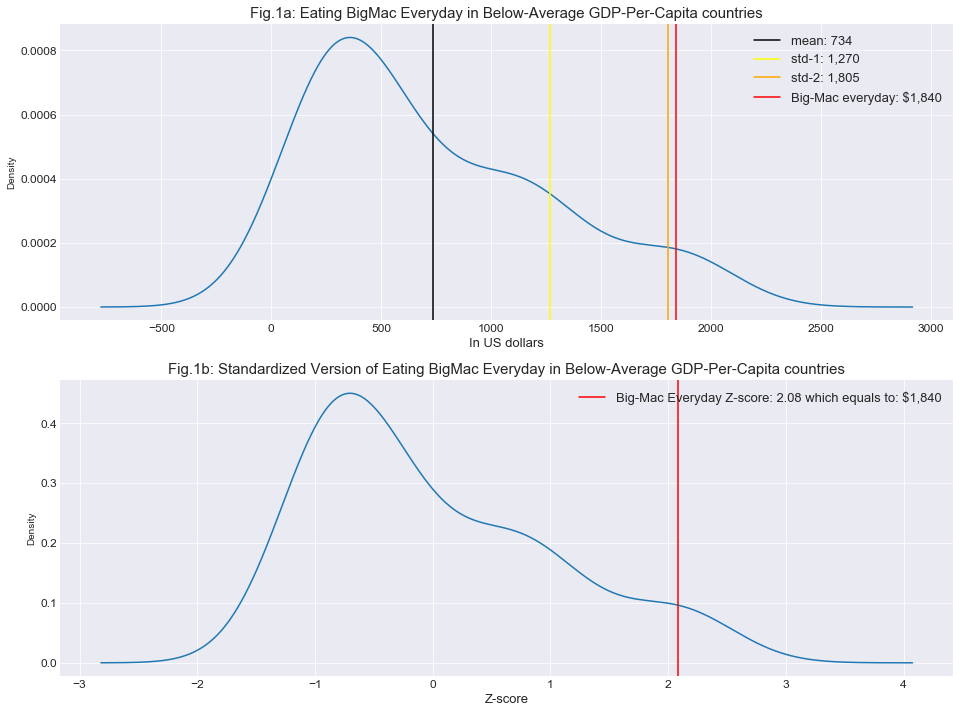

In [78]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(2,1,1)
df_combined_belowaverage_subset['mean_gdp_percapita'].plot(kind='kde',ax=ax1,label='')
plt.title('Fig.1a: Eating BigMac Everyday in Below-Average GDP-Per-Capita countries',fontsize=15)
plt.axvline(x=mean_val,c='black',label='mean: ' + pretty_number(mean_val))
plt.axvline(x=std1_val,c='yellow',label='std-1: ' + pretty_number(std1_val))
plt.axvline(x=std2_val,c='orange',label='std-2: ' + pretty_number(std2_val))
plt.axvline(x=BIG_MAC_EVERYDAY,c='red',label='Big-Mac everyday: ' + money(BIG_MAC_EVERYDAY))
plt.xlabel('In US dollars',fontsize=13)
common_ticks_legends_format(12,13)

#standardized form
ax2 = fig.add_subplot(2,1,2)
df_combined_belowaverage_subset['z_mean_gdp_percapita'].plot(kind='kde',ax=ax2,label='')
plt.title('Fig.1b: Standardized Version of Eating BigMac Everyday in Below-Average GDP-Per-Capita countries',fontsize=15)
plt.axvline(BIG_MAC_EVERYDAY_Z_score,c='red',label='Big-Mac Everyday Z-score: ' + str(BIG_MAC_EVERYDAY_Z_score) \
           + ' which equals to: ' + money(BIG_MAC_EVERYDAY))
plt.xlabel('Z-score',fontsize=13)
common_ticks_legends_format(12,13)

plt.show()

From Fig.1 above, we can see that eating big-mac everyday is very expensive in below-average gdp-percapita countries. The z-score of eating Big-Mac Everyday is 2.08, which means only approximately (1-0.9812) 1.88% of the population can afford this habit!

<a id='second_test'></a>
### Second, we test average gdp-percapita countries

In [79]:
#Calculate the Z-score for BIG-MAC everyday in average gdp-percapita countries
BIG_MAC_EVERYDAY_Z_score = \
    round(calc_z_score_given_value(df_combined_50_75_subset['mean_gdp_percapita'],BIG_MAC_EVERYDAY),2)

In [80]:
BIG_MAC_EVERYDAY_Z_score

-1.57

>Now the BIG_MAC_EVERYDAY z-score is -1.57, which means that unlike the z-score above,<br>
>it is negative and it quite far away from the mean. This means that majority of people in<br> 
average gdp_percapita countries can afford BIG MAC meal for lunch everyday.<br>
>



In [81]:
#Calculate Data for plotting graphs
mean_val, std1_val, std2_val = \
    calc_mean_within_std1_std2_left(df_combined_50_75_subset['mean_gdp_percapita'])
mean_val = int(mean_val)
std1_val = int(std1_val)
std2_val = int(std2_val)

In [82]:
mean_val,std1_val,std2_val

(4459, 2756, 1053)

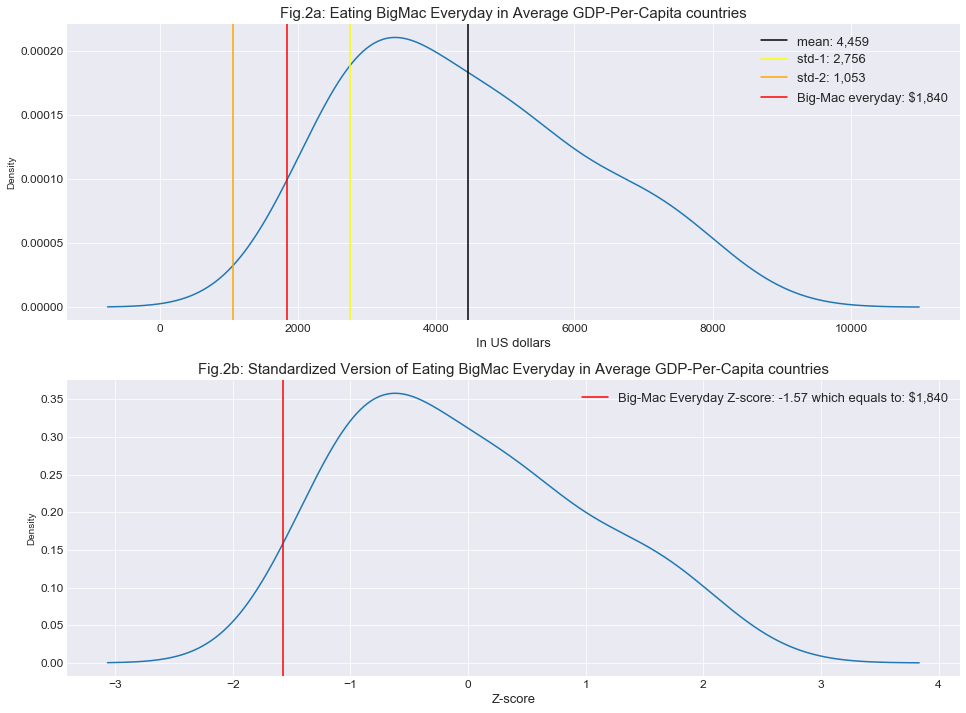

In [83]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(2,1,1)
df_combined_50_75_subset['mean_gdp_percapita'].plot(kind='kde',ax=ax1,label='')
plt.title('Fig.2a: Eating BigMac Everyday in Average GDP-Per-Capita countries',fontsize=15)
plt.axvline(x=mean_val,c='black',label='mean: ' + pretty_number(mean_val))
plt.axvline(x=std1_val,c='yellow',label='std-1: ' + pretty_number(std1_val))
plt.axvline(x=std2_val,c='orange',label='std-2: ' + pretty_number(std2_val))
plt.axvline(x=BIG_MAC_EVERYDAY,c='red',label='Big-Mac everyday: ' + money(BIG_MAC_EVERYDAY))
plt.xlabel('In US dollars',fontsize=13)
common_ticks_legends_format(12,13)

#standardized form
ax2 = fig.add_subplot(2,1,2)
df_combined_50_75_subset['z_mean_gdp_percapita'].plot(kind='kde',ax=ax2,label='')
plt.title('Fig.2b: Standardized Version of Eating BigMac Everyday in Average GDP-Per-Capita countries',fontsize=15)
plt.axvline(BIG_MAC_EVERYDAY_Z_score,c='red',label='Big-Mac Everyday Z-score: ' + str(BIG_MAC_EVERYDAY_Z_score) \
           + ' which equals to: ' + money(BIG_MAC_EVERYDAY))
plt.xlabel('Z-score',fontsize=13)
common_ticks_legends_format(12,13)

plt.show()

From Fig.2, we can see that Big-Mac Everyday Z-score lies within first and second standard deviation with
a z-score of -1.57. This means that it is 1.57 standard deviation away from  the mean to the left. Checking Z-table,
this corresponds to 5.82%, which approximately means that about 5.28% of the population can't afford eating Big-Mac
everyday in average gdp-percapita countries.

<a id='third_test'></a>
### Third, we test above-average gdp-percapita countries

In [84]:
#Calculate the Z-score for BIG-MAC everyday in above-average gdp-percapita countries
BIG_MAC_EVERYDAY_Z_score = \
    round(calc_z_score_given_value(df_combined_above75_subset['mean_gdp_percapita'],BIG_MAC_EVERYDAY),2)

In [85]:
BIG_MAC_EVERYDAY_Z_score

-2.5

In [86]:
#Calculate Data for plotting graphs
mean_val, std1_val, std2_val = \
    calc_mean_within_std1_std2_left(df_combined_above75_subset['mean_gdp_percapita'])
mean_val = int(mean_val)
std1_val = int(std1_val)
std2_val = int(std2_val)

In [87]:
mean_val,std1_val,std2_val

(19052, 12044, 5037)

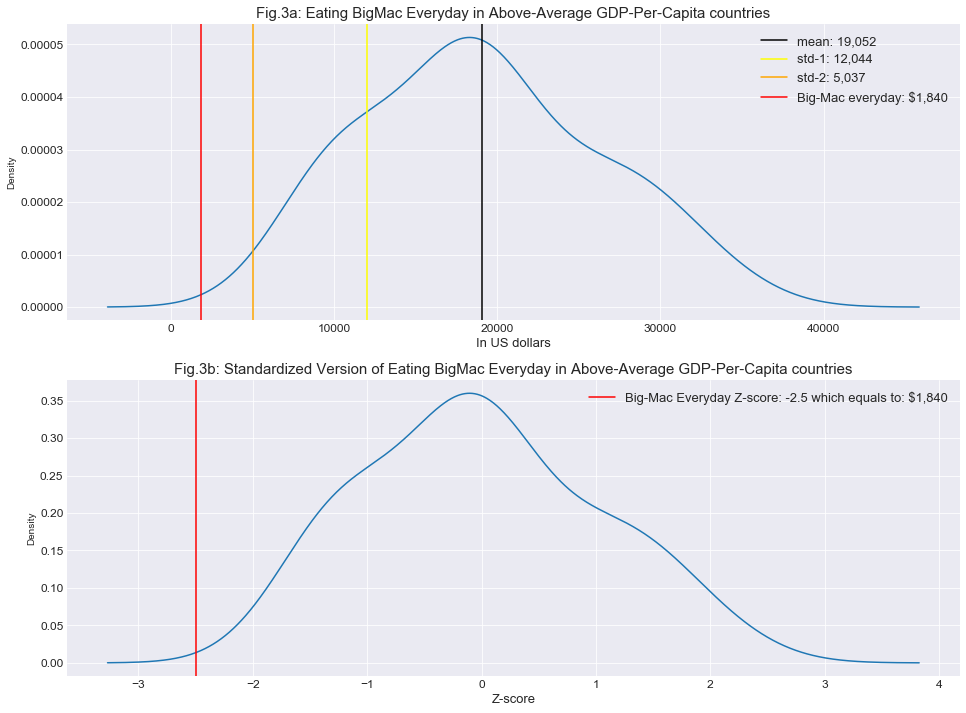

In [88]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(2,1,1)
df_combined_above75_subset['mean_gdp_percapita'].plot(kind='kde',ax=ax1,label='')
plt.title('Fig.3a: Eating BigMac Everyday in Above-Average GDP-Per-Capita countries',fontsize=15)
plt.axvline(x=mean_val,c='black',label='mean: ' + pretty_number(mean_val))
plt.axvline(x=std1_val,c='yellow',label='std-1: ' + pretty_number(std1_val))
plt.axvline(x=std2_val,c='orange',label='std-2: ' + pretty_number(std2_val))
plt.axvline(x=BIG_MAC_EVERYDAY,c='red',label='Big-Mac everyday: ' + money(BIG_MAC_EVERYDAY))
plt.xlabel('In US dollars',fontsize=13)
common_ticks_legends_format(12,13)

#standardized form
ax2 = fig.add_subplot(2,1,2)
df_combined_above75_subset['z_mean_gdp_percapita'].plot(kind='kde',ax=ax2,label='')
plt.title('Fig.3b: Standardized Version of Eating BigMac Everyday in Above-Average GDP-Per-Capita countries',fontsize=15)
plt.axvline(BIG_MAC_EVERYDAY_Z_score,c='red',label='Big-Mac Everyday Z-score: ' + str(BIG_MAC_EVERYDAY_Z_score) \
           + ' which equals to: ' + money(BIG_MAC_EVERYDAY))
plt.xlabel('Z-score',fontsize=13)
common_ticks_legends_format(12,13)

plt.show()

From Fig.3, we can see that eating big-mac everyday is very affordable in above-average
gdp-percapita countries. The z-score of eating Big-Mac Everyday is -2.5, which means that
only approximately 0.62% of its population can't afford this habit.

<a id='resquestion2'></a>
### Research Question 2  -- Investigating Correlation

In [89]:
# For the first correlation investigation, I will use df_combined_economic_status dataframe
# Recall that this dataframe contains ALL data -- below_average gdp_percapita, 
# average gdp_percapita and above_average gdp_percapita. 
df_combined_economic_status.head(3)

,name,sub-region,mean_gdp_percapita,mean_exports,mean_imports,mean_fdi,mean_gdp,economic_status
0,Algeria,Northern Africa,1833.531263,29.661752,26.967667,0.73115,4.637624e+10,below_average
1,Antigua and Barbuda,Latin America and the Caribbean,8772.038285,68.531756,78.470846,8.40268,6.481746e+08,above_average
2,Argentina,Latin America and the Caribbean,7326.550290,12.033307,9.834957,1.45672,2.411955e+11,average


#### Table 1: combined gdp_percapita correlation

In [90]:
# I will do a bi-variate correlation / linear regression analysis.
# Correlation can be found using this:
results_corr_combined = \
    df_combined_economic_status[['mean_exports','mean_imports','mean_fdi','mean_gdp','mean_gdp_percapita']].corr()
results_corr_combined

,mean_exports,mean_imports,mean_fdi,mean_gdp,mean_gdp_percapita
mean_exports,1.000000,0.863527,0.442173,-0.190675,0.233305
mean_imports,0.863527,1.000000,0.344363,-0.239082,0.043713
mean_fdi,0.442173,0.344363,1.000000,-0.044569,0.311620
mean_gdp,-0.190675,-0.239082,-0.044569,1.000000,0.453384
mean_gdp_percapita,0.233305,0.043713,0.311620,0.453384,1.000000


In [91]:
# correlation between exports and gdp_percapita
combined_exports_gdp_percapita_r = \
        round(results_corr_combined.loc['mean_exports']['mean_gdp_percapita'],2)
# correlation btw imports and gdp_percapita
combined_imports_gdp_percapita_r = \
        round(results_corr_combined.loc['mean_imports']['mean_gdp_percapita'],2)
# correlation btw fdi and gdp_percapita
combined_fdi_gdp_percapita_r = \
        round(results_corr_combined.loc['mean_fdi']['mean_gdp_percapita'],2)
# correlation btw gdp and gdp_percapita
combined_gdp_gdp_percapita_r = \
        round(results_corr_combined.loc['mean_gdp']['mean_gdp_percapita'],2)

# show results in tuple
# these results will be used in the plot below
combined_exports_gdp_percapita_r, combined_imports_gdp_percapita_r, \
    combined_fdi_gdp_percapita_r, combined_gdp_gdp_percapita_r

(0.23, 0.04, 0.31, 0.45)

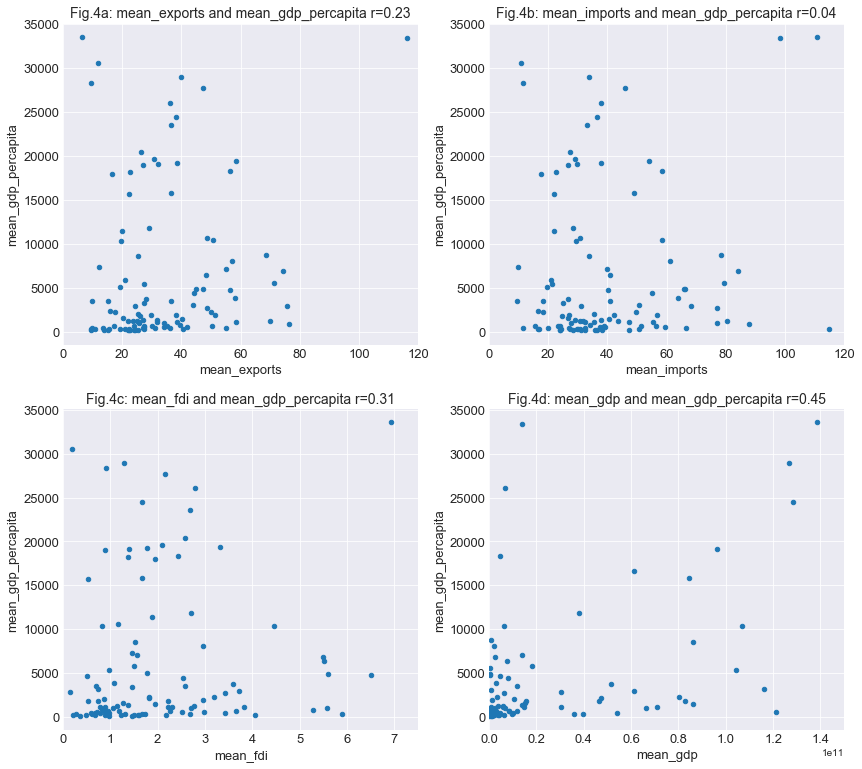

In [92]:
fig = plt.figure(figsize=(14,13))

ax1 = fig.add_subplot(2,2,1)
df_combined_economic_status.plot(x='mean_exports',y='mean_gdp_percapita',kind='scatter',ax=ax1, \
                xlim=(0,120),label='')
plt.title('Fig.4a: mean_exports and mean_gdp_percapita r=' + str(combined_exports_gdp_percapita_r),fontsize=14)
plt.ylabel('mean_gdp_percapita',fontsize=13)
plt.xlabel('mean_exports',fontsize=13)
common_ticks_format(13)

ax2 = fig.add_subplot(2,2,2)
df_combined_economic_status.plot(x='mean_imports',y='mean_gdp_percapita',kind='scatter',ax=ax2, \
                xlim=(0,120),label='')
plt.title('Fig.4b: mean_imports and mean_gdp_percapita r=' + \
              str(combined_imports_gdp_percapita_r),fontsize=14)
plt.ylabel('mean_gdp_percapita',fontsize=13)
plt.xlabel('mean_imports',fontsize=13)
common_ticks_format(13)

ax3 = fig.add_subplot(2,2,3)
df_combined_economic_status.plot(x='mean_fdi',y='mean_gdp_percapita',kind='scatter',ax=ax3, \
                xlim=(0,7.5),label='')
plt.title('Fig.4c: mean_fdi and mean_gdp_percapita r=' + \
          str(combined_fdi_gdp_percapita_r),fontsize=14)
plt.ylabel('mean_gdp_percapita',fontsize=13)
plt.xlabel('mean_fdi',fontsize=13)
common_ticks_format(13)

ax4 = fig.add_subplot(2,2,4)
df_combined_economic_status.plot(x='mean_gdp',y='mean_gdp_percapita',kind='scatter',ax=ax4, \
                xlim=(0,150000000000),label='')
plt.title('Fig.4d: mean_gdp and mean_gdp_percapita r=' + \
          str(combined_gdp_gdp_percapita_r),fontsize=14)
plt.ylabel('mean_gdp_percapita',fontsize=13)
plt.xlabel('mean_gdp',fontsize=13)
common_ticks_format(13)
plt.show()

>Referring to Fig.4c and Fig.4d, correlations between mean_fdi and mean_gdp_percapita is 0.31
and correlations between mean_gdp and mean_gdp_percapita is 0.45 respectively. This is a 
moderate correlation. In other words, if there is a rise in mean_fdi or mean_gdp, there is
a corresponding rise in mean_gdp_percapita. 
>
>No such relation though for mean_exports and mean_gdp_percapita. Refer to Fig.4a and 4b above. Recall from the outset 
that I'm trying to prove there is a relationship between these variables -- exports
and gdp_percapita through my statement "Export-led economic growth". 
>
>However, looking closely at Fig.4a, there is a cluster of data points under 5,000 between
mean_exports 20 and 80. If there's a way to remove these "outliers", correlations btw.
export and gdp_percapita will be strong. This point will be discussed again later below.

#### Table 2: below_average gdp_percapita correlation

In [93]:
results_corr_below_average = \
df_combined_belowaverage_subset[['mean_exports','mean_imports','mean_fdi','mean_gdp','mean_gdp_percapita']].corr()
results_corr_below_average

,mean_exports,mean_imports,mean_fdi,mean_gdp,mean_gdp_percapita
mean_exports,1.000000,0.700948,0.539160,-0.199878,0.340708
mean_imports,0.700948,1.000000,0.525051,-0.290582,0.092841
mean_fdi,0.539160,0.525051,1.000000,-0.061393,-0.034751
mean_gdp,-0.199878,-0.290582,-0.061393,1.000000,0.019450
mean_gdp_percapita,0.340708,0.092841,-0.034751,0.019450,1.000000


#### Table 3: average gdp_percapita correlation

In [94]:
results_corr_average = \
df_combined_50_75_subset[['mean_exports','mean_imports','mean_fdi','mean_gdp','mean_gdp_percapita']].corr()
results_corr_average

,mean_exports,mean_imports,mean_fdi,mean_gdp,mean_gdp_percapita
mean_exports,1.000000,0.902034,0.442421,-0.601148,0.253545
mean_imports,0.902034,1.000000,0.517836,-0.598900,0.141065
mean_fdi,0.442421,0.517836,1.000000,-0.213125,0.291969
mean_gdp,-0.601148,-0.598900,-0.213125,1.000000,-0.040297
mean_gdp_percapita,0.253545,0.141065,0.291969,-0.040297,1.000000


#### Table 4: above-average gdp_percapita correlation

In [95]:
results_corr_ab_average = \
df_combined_above75_subset[['mean_exports','mean_imports','mean_fdi','mean_gdp','mean_gdp_percapita']].corr()
results_corr_ab_average

,mean_exports,mean_imports,mean_fdi,mean_gdp,mean_gdp_percapita
mean_exports,1.000000,0.979928,0.495640,-0.330215,0.056327
mean_imports,0.979928,1.000000,0.424612,-0.344163,-0.035815
mean_fdi,0.495640,0.424612,1.000000,-0.112359,0.386282
mean_gdp,-0.330215,-0.344163,-0.112359,1.000000,0.378767
mean_gdp_percapita,0.056327,-0.035815,0.386282,0.378767,1.000000


In [96]:
# getting correlation data for df_combined_economic_status
combined_exports_gdp_percapita_r = \
        round(results_corr_combined.loc['mean_exports']['mean_gdp_percapita'],2)
combined_imports_gdp_percapita_r = \
        round(results_corr_combined.loc['mean_imports']['mean_gdp_percapita'],2)
combined_fdi_gdp_percapita_r = \
        round(results_corr_combined.loc['mean_fdi']['mean_gdp_percapita'],2)
combined_gdp_gdp_percapita_r = \
        round(results_corr_combined.loc['mean_gdp']['mean_gdp_percapita'],2)

# show results in tuple
# these results will be used in the plot below
combined_list = [combined_exports_gdp_percapita_r, combined_imports_gdp_percapita_r, \
                combined_fdi_gdp_percapita_r, combined_gdp_gdp_percapita_r]
combined_exports_gdp_percapita_r, combined_imports_gdp_percapita_r, \
    combined_fdi_gdp_percapita_r, combined_gdp_gdp_percapita_r

(0.23, 0.04, 0.31, 0.45)

In [97]:
# getting correlation data for (below-average subset) df_combined_below_average_subset
b_average_exports_gdp_percapita_r = \
        round(results_corr_below_average.loc['mean_exports']['mean_gdp_percapita'],2)
b_average_imports_gdp_percapita_r = \
        round(results_corr_below_average.loc['mean_imports']['mean_gdp_percapita'],2)
b_average_fdi_gdp_percapita_r = \
        round(results_corr_below_average.loc['mean_fdi']['mean_gdp_percapita'],2)
b_average_gdp_gdp_percapita_r = \
        round(results_corr_below_average.loc['mean_gdp']['mean_gdp_percapita'],2)

# show results in tuple
b_average_list = [b_average_exports_gdp_percapita_r, b_average_imports_gdp_percapita_r, \
                 b_average_fdi_gdp_percapita_r, b_average_gdp_gdp_percapita_r]
b_average_exports_gdp_percapita_r, b_average_imports_gdp_percapita_r, \
    b_average_fdi_gdp_percapita_r, b_average_gdp_gdp_percapita_r

(0.34, 0.09, -0.03, 0.02)

In [98]:
# getting correlation data for (average subset) df_combined_50_75_subset
average_exports_gdp_percapita_r = \
        round(results_corr_average.loc['mean_exports']['mean_gdp_percapita'],2)
average_imports_gdp_percapita_r = \
        round(results_corr_average.loc['mean_imports']['mean_gdp_percapita'],2)
average_fdi_gdp_percapita_r = \
        round(results_corr_average.loc['mean_fdi']['mean_gdp_percapita'],2)
average_gdp_gdp_percapita_r = \
        round(results_corr_average.loc['mean_gdp']['mean_gdp_percapita'],2)

# show results in tuple
average_list = [average_exports_gdp_percapita_r, average_imports_gdp_percapita_r, \
                 average_fdi_gdp_percapita_r, average_gdp_gdp_percapita_r]
average_exports_gdp_percapita_r, average_imports_gdp_percapita_r, \
    average_fdi_gdp_percapita_r, average_gdp_gdp_percapita_r

(0.25, 0.14, 0.29, -0.04)

In [99]:
# getting correlation data for (above-average subset) df_combined_above_75_subset
ab_average_exports_gdp_percapita_r = \
        round(results_corr_ab_average.loc['mean_exports']['mean_gdp_percapita'],2)
ab_average_imports_gdp_percapita_r = \
        round(results_corr_ab_average.loc['mean_imports']['mean_gdp_percapita'],2)
ab_average_fdi_gdp_percapita_r = \
        round(results_corr_ab_average.loc['mean_fdi']['mean_gdp_percapita'],2)
ab_average_gdp_gdp_percapita_r = \
        round(results_corr_ab_average.loc['mean_gdp']['mean_gdp_percapita'],2)

# show results in tuple
ab_average_list = [ab_average_exports_gdp_percapita_r, ab_average_imports_gdp_percapita_r, \
                 ab_average_fdi_gdp_percapita_r, ab_average_gdp_gdp_percapita_r]
ab_average_exports_gdp_percapita_r, ab_average_imports_gdp_percapita_r, \
    ab_average_fdi_gdp_percapita_r, ab_average_gdp_gdp_percapita_r

(0.06, -0.04, 0.39, 0.38)

<a id='combined_fig_5'></a>
### Combine data from table 1,  table 2, table 3 and table 4 into one plot!

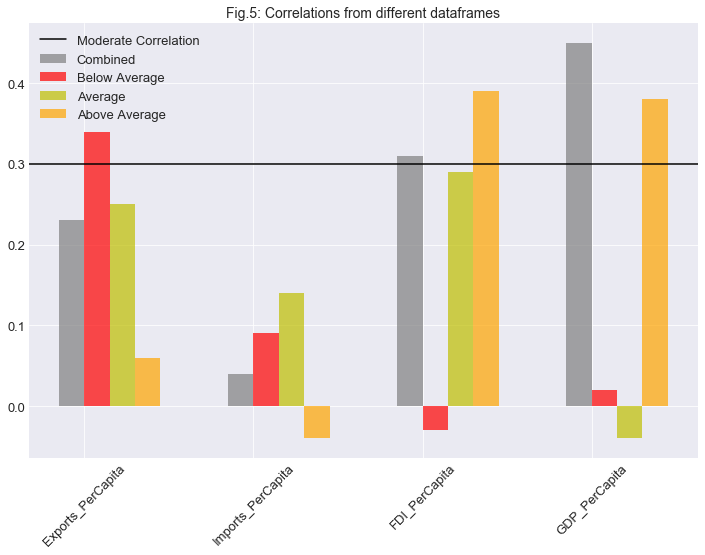

In [100]:
# Inspired by Graphing Technique from Case Study 1
x = np.arange(0,4)
width=0.15

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,1,1)
ax1.bar(x,combined_list,width,color='grey',label='Combined',alpha=0.7)
ax1.bar(x+width,b_average_list,width,color='r',label='Below Average',alpha=.7)
ax1.bar(x+(2*width),average_list,width,color='y',label='Average',alpha=0.7)
ax1.bar(x+(3*width),ab_average_list,width,color='orange',label='Above Average',alpha=0.7)

plt.title('Fig.5: Correlations from different dataframes',fontsize=14)
xlabels = ['Exports_PerCapita','Imports_PerCapita','FDI_PerCapita','GDP_PerCapita']
x_tick_location = x + width/2
plt.xticks(x_tick_location,xlabels,rotation=45,fontsize=13)
plt.axhline(0.3,label='Moderate Correlation',c='black')
plt.yticks(fontsize=13)
plt.legend(fontsize=13)
plt.show()

>Recall that I want to show that countries got rich through 
>export-led growth following the example of Four Asian Tigers -- Singapore,
>South Korea, Taiwan and Hong Kong. However from Fig.5 above, the correlation
>of Exports and PerCapitaGDP in Above-Average (rich) countries (orange bar) is very low at
>less than 0.1 while the correlation (Exports and PerCapitaGDP) in below_average (poor)
>countries (red bar) is moderate at 0.31.
>
>The low correlation (of Exports and PerCapitaGDP) in rich countries seem to suggest
>that exports (as proportions of GPD) in rich countries are low. However, Fig.6 below
>shows otherwise. In fact, the mean "Exports as proportion of GDP" in above-average
>(rich) countries is around 41% (Refer to Fig.6). This is a high number relative to 
>below_average countries. 
>
>**Why the correllation of Exports (as proportion of GDP) and PerCapitaGDP in rich
>countries (Fig.5) doesn't reflect this relative high number of Exports as proportion of 
>GDP (Fig.6)?** 
>
>If you look closer at Fig.4a, you can see there are 
>clusters of low mean_gdp_percapita data points (below USD 5000) hovering from 20%
>to approx. 80% of mean_exports (as proportion of GDP). If these outliers can be
>taken out from the plot, correlation of mean_exports and mean_gdp_percapita will definitely
>get stronger. To remove these outliers, we cannot just get rid of them willy-nilly. There 
>are just too many outliers.
>We need other independent(explanatory) variables such as education level, manufacturing data,
>agricultural data and breakdown of exports -- exports that come from manufacturing sector, 
>agricultural sector or primary sector such as coals,oil and diamonds -- to filter these
>outliers.
>
>The low correlation of imports (as a proportion of GDP) and gdp_percapita in Fig.5 also doesn't
>reflect the high number of imports as a proportion of GDP in Fig.7. Again this is due to many
>outliers that can be seen in Fig.4b. We need more independent (explanatory) variables to filter
>these outliers as discussed above.
>
>FDI and GDPPercapita correlation number in Fig.5 though somewhat agrees with the
>FDI (as a proportion of GDP) in Fig.8 The correlation of 0.4 in above-average 
>gdp_percapita countries agree with the high number of FDI as a proportion of GDP 
>in rich countries (above-average gdppercapita). Filtering outliers out will make
>this correlation more pronounced in my opinion.
>
>The highest correlation occurs in GDP and GDP_percapita. This is not surprising since gdp_percapita and gdp is related. gdp_percapita is calculated by dividing gdp by the country's population.
>

<a id='using_pivot_table'></a>
All the efforts and time to <a href='#CleaningThirdStage'>clean data </a> has enabled me to use pandas.pivot_table() below.
It's a real time-saver.

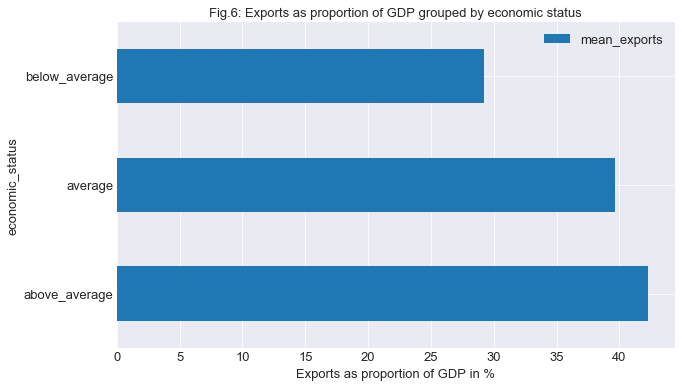

In [101]:
pd.pivot_table(df_combined_economic_status,index=['economic_status'],values='mean_exports')\
        .plot(kind='barh',figsize=(10,6))
plt.title('Fig.6: Exports as proportion of GDP grouped by economic status',fontsize=13)
plt.xlabel('Exports as proportion of GDP in %',fontsize=13)
common_ticks_legends_format(13,13)
plt.ylabel('economic_status',fontsize=13)
plt.show()

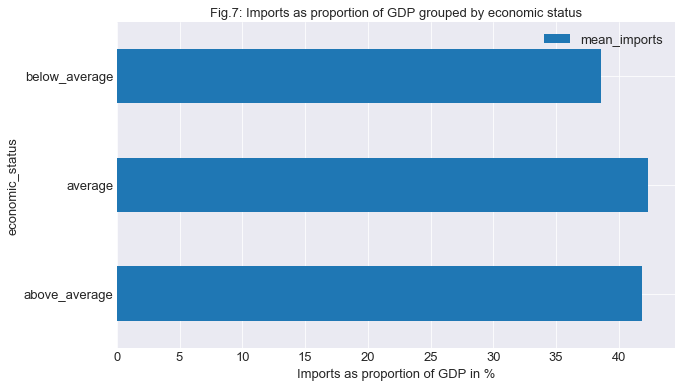

In [102]:
pd.pivot_table(df_combined_economic_status,index=['economic_status'],values='mean_imports')\
        .plot(kind='barh',figsize=(10,6))
plt.title('Fig.7: Imports as proportion of GDP grouped by economic status',fontsize=13)
plt.xlabel('Imports as proportion of GDP in %',fontsize=13)
common_ticks_legends_format(13,13)
plt.ylabel('economic_status',fontsize=13)
plt.show()

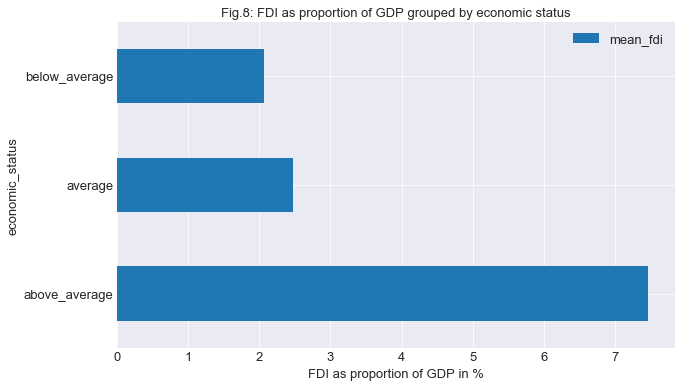

In [103]:
pd.pivot_table(df_combined_economic_status,index=['economic_status'],values='mean_fdi')\
        .plot(kind='barh',figsize=(10,6))
plt.title('Fig.8: FDI as proportion of GDP grouped by economic status',fontsize=13)
plt.xlabel('FDI as proportion of GDP in %',fontsize=13)
common_ticks_legends_format(13,13)
plt.ylabel('economic_status',fontsize=13)
plt.show()

<a id='resquestion3'></a>
### Research Question 3  -- Investigating Single DataPoint: Singapore

In [104]:
# I only plot Singapore data. There is no data for Taiwan, hongkong and South Korea

In [105]:
#Getting the gdp growth of Singapore
df_gdp_market_above_average = dfc_gdp_market_T[df_combined_above75_subset['name']]
df_gdp_rate_above_average = df_gdp_market_above_average.pct_change()
df_gdp_rate_above_average.head(3)

,Antigua and Barbuda,Australia,Austria,Bahamas,Canada,Cyprus,Denmark,Finland,France,Germany,...,New Zealand,Norway,Portugal,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,United Kingdom,United States
1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971,0.0,0.040192,0.051150,0.016265,0.041177,0.0,0.030019,0.023569,0.053306,0.031327,...,0.0,0.056178,0.066317,0.199427,0.120502,0.046495,0.009446,0.0,0.020242,0.034580
1972,0.0,0.039312,0.062079,-0.034973,0.054459,0.0,0.041750,0.077355,0.045374,0.043003,...,0.0,0.052680,0.080157,0.234938,0.135030,0.081497,0.022887,0.0,0.035665,0.055218


In [106]:
singapore_gdp_rate = round(df_gdp_rate_above_average.mean()['Singapore'] * 100,2)
singapore_gdp_rate

7.45

In [107]:
#to read moving average: https://www.youtube.com/watch?time_continue=89&v=T2mQiesnx8s
# format xticks:
# link: https://stackoverflow.com/questions/25973581/how-do-i-format-axis-number-format-to-thousands-with-a-comma-in-matplotlib

In [108]:
df_gdp_rate_above_average.reset_index(inplace=True)
df_gdp_rate_above_average.tail(2)

,index,Antigua and Barbuda,Australia,Austria,Bahamas,Canada,Cyprus,Denmark,Finland,France,...,New Zealand,Norway,Portugal,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,United Kingdom,United States
39,2009,-0.103457,0.014484,-0.038100,-0.048600,-0.027698,-0.016662,-0.058337,-0.083543,-0.031471,...,-0.004707,-0.016671,-0.029084,0.000965,-0.009797,-0.037408,-0.050277,-0.01878,-0.043733,-0.035275
40,2010,-0.088820,0.022569,0.023147,0.001787,0.032149,0.011400,0.012956,0.037315,0.016631,...,0.019000,0.006765,0.014013,0.046419,0.147632,-0.000695,0.061527,0.02714,0.020922,0.030217


In [109]:
# Using the technique from Project 1 -- Moving Average
# Calculating Moving Average for Singapore GDP Rate
rollingWindow = 8
df_movingAverage = simplifiedRollingMean(rollingWindow, df_gdp_rate_above_average)
#df_movingAverage.head()

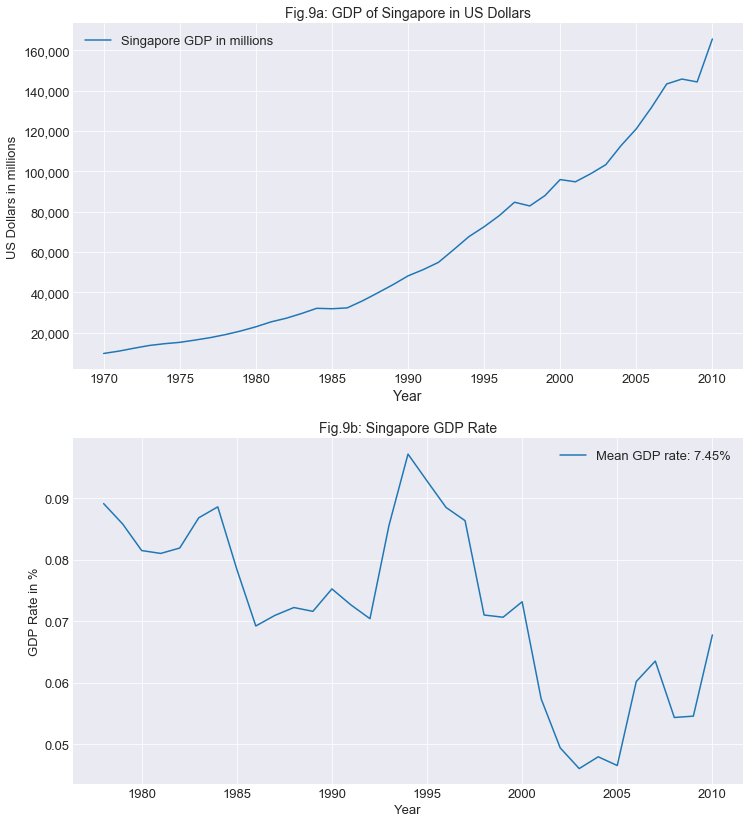

In [110]:

fig = plt.figure(figsize=(12,14))
ax1 = fig.add_subplot(2,1,1)
dfc_gdp_market_T['Singapore'].apply(lambda x: x /1000000).plot(ax=ax1,label='Singapore GDP in millions')
plt.title('Fig.9a: GDP of Singapore in US Dollars',fontsize=14)
plt.ylabel('US Dollars in millions',fontsize=13)
plt.xlabel('Year',fontsize=14)
ax1.get_yaxis().set_major_formatter( \
                    matplotlib.ticker.FuncFormatter(lambda x,p: format(int(x),',')))
common_ticks_legends_format(13,13)

ax2 = fig.add_subplot(2,1,2)
#df_gdp_rate_above_average['Singapore'].plot(ax=ax2,label='Mean GDP rate: ' + str(singapore_gdp_rate) + '%')
ax2.plot(df_movingAverage['index'],df_movingAverage['Singapore'], \
            label='Mean GDP rate: ' + str(singapore_gdp_rate) + '%')
plt.title('Fig.9b: Singapore GDP Rate',fontsize=14)
plt.ylabel('GDP Rate in %',fontsize=13)
plt.xlabel('Year',fontsize=13)
common_ticks_legends_format(13,13)

plt.show()

<a id='table_5'></a>
#### Table 5: Singapore Data among South-eastern Asia nations

In [111]:
df_combined_economic_status[df_combined_economic_status['sub-region']=='South-eastern Asia']

,name,sub-region,mean_gdp_percapita,mean_exports,mean_imports,mean_fdi,mean_gdp,economic_status
46,Indonesia,South-eastern Asia,614.119061,27.490039,23.937109,0.713812,1.211541e+11,below_average
60,Malaysia,South-eastern Asia,2914.168937,75.682001,68.180029,3.725821,6.140845e+10,average
79,Philippines,South-eastern Asia,1036.955532,31.927447,35.567929,1.064964,6.648164e+10,below_average
86,Singapore,South-eastern Asia,16638.283681,176.475260,168.059919,10.528263,6.135172e+10,above_average
96,Thailand,South-eastern Asia,1446.039028,40.218997,40.484161,1.951779,8.632533e+10,below_average


In [112]:
# Calculation for Singapore MIN and MAX GDP
pretty_number(dfc_gdp_market_T['Singapore'].min()),pretty_number(dfc_gdp_market_T['Singapore'].max())

('9,603,756,795', '165,706,962,574')

> From the calculation above, the Singapore has a MIN GDP of 9.6 billion USD and <br>
> a MAX GDP of 165.7 billion USD at the end of data point of Year 2010. Therefore, <br>
> Singapore grow by a factor of 16 ((165-9.6)/9.6) in 40 years (1970 - 2010).
>
> In addition to phenomenal growth rate, Singapore has exceptional Exports, Imports and <br>
> FDI (as proportions of GDP).
> 
> From Table 5, Exports (as a proportion of GDP) is 1.76 times its own GDP. Compare this<br>
> with Fig.6 where the average exports (as a proportion of GDP) is just around 0.42 times <br>
> its own GDP for above_average category.
>
> From Table 5, Imports (as a proportion of GDP) is 1.68 times its own GDP. Compare this<br>
> with Fig.7 where the average imports (as a proportion of GDP) is just around 0.42 times its<br>
> own GDP for above-average category.
>
> From Table 5, FDI (as a proportion of GDP) is around 0.1 its own GDP. This may seem like a small<br>
> number when comparing with figures for Exports and Imports above. However, when comparing with <br>
> Fig.8, the highest mean imports (as a proportion of GDP) is only 0.72 times its own GDP. <br>
> Singapore's FDI is still high.
>
> Therefore, there is a clear correlation between high GDP per capita and exports level for <br>
> Singapore. The story of prosperity through export-led growth is indeed true.<br>
> The question now is how to attain this high exports, FDI and imports for a country. <br>
> To answer this, we have to dig other independent(explanatory) variables such as education, <br> manufacturing, agriculture, natural resources and quality of exports -- whether it is dependent on manufacture, agricultural products or raw materials such as coal, oil and diamonds.
>
>
>


<a id='conclusions'></a>
## Conclusions

> Wrangling data has taken approximately 60% of the project's time. Gathering and assembling data
> in <a href='#awesome_format'/>a combined format </a>has been worth the time. Refer to <a href='#combined_fig_5'/>Figure 5</a> and <a href='#using_pivot_table'/>using pivot table to plot graph.</a> Usually this will involve counting instances in a dictionary in a for loop. With pivot_table, plotting this type of graph is so much easier. Of course before you use the pivot_table,
you have to assemble the underlying data in a combined format.

> Eating Big Mac everyday is affordable in average and rich (above-average) countries but <a href='#first_test'/>very expensive in below-average countries.</a> Converting nominal value into z-score can be very useful. For example, the Big-Mac Everyday z-score for below-average country is 2.08. We can immediately tell that only 1.88% of the population can afford this habit.

> I also posed a question from what I read frequently from articles -- hardcopy and online alike. **Success story of Four Asian Tigers through export-led growth.** From the dissection of single-data point -- Singapore, the question posed is indeed true and more. Not only is the Export (as a proportion of GDP) value high, the value of Import and FDI (as a proportion of GDP) is also very high (especially compared to countries in the same and different economic category). Refer to <a href='#table_5'/>Table 5</a> and <a href='#using_pivot_table'/>pivot table graphs.</a>
> 

> So we know there is a strong positive correlation of rich country (high gdp_percapita) and export value based on data from Singapore. Does this correlation hold true for other countries? If countries have high Export (as a proportion of GDP) values, can we conclude that those countries are rich (high gdp_percapita)?
>

> **If we look only** at <a href='#using_pivot_table'/>From Fig.6, 7 and 8</a>, the answer is **TENTATIVELY** yes. Not only do average and above-average countries have high Export values, they also have high Import and FDI values (as a proportion of GDP). However if you look at <a href='#combined_fig_5'/>Fig.5</a>, the correlation between export and gdp_percapita is very low (less than 0.1) in rich (above-average; orange bar) countries. Why? This can be explained if you look at Fig.4a. (I realize that Fig.4a is obtained from df_combined_economic_status dataset and not from df_combined_above75_subset dataset but I still reckon that they will have the same shape because of its low correlation number). Looking closer at Fig.4a, you can see there are clusters of low mean_gdp_percapita data points (below USD 5000) hovering from 20% to approx. 80% of mean_exports (as proportion of GDP). If these outliers can be taken out from the plot, correlation of mean_exports and mean_gdp_percapita will definitely get stronger. To remove these outliers, we cannot just get rid of them willy-nilly. There are just too many outliers. We need other independent(explanatory) variables such as education level, manufacturing data, agricultural data and breakdown of exports -- exports that come from manufacturing sector, agricultural sector or primary sector such as coals,oil and diamonds to filter -- these outliers.
>
> Therefore we cannot conclusively say that countries are rich if they have high export values. We need more data to fine-tune our Export, Import and FDI values. Having said that, other countries can still learn from the success story of Singapore. <a href='https://www.straitstimes.com/singapore/singapores-visionary-mr-lee-kuan-yew-inspires-followers-in-africa-including-rwanda'/>Rwanda's Paul Kagame has been known to take a page from Singapore's Lee Kuan Yew.</a>